HPA_KF
POTデータの範囲 17.63 ~ 35.22
最尤推定 ξ: 0.074702370914978 σ: 4.036608779823444 RV: 49.550976930533935
RV： [36.53244879385098, 49.550976930533935, 78.20455896444741]
HFA_KF_c0
POTデータの範囲 15.41 ~ 35.12
最尤推定 ξ: 0.12562814070351802 σ: 5.802971893790702 RV: 70.04944353168504
RV： [47.36513884827663, 70.04944353168504, 76.97145914371389]
HPA_YS
POTデータの範囲 13.97 ~ 29.44
最尤推定 ξ: 0.2740211122727736 σ: 3.456469755592621 RV: 70.59432650426592
RV： [37.04825900343151, 70.59432650426592, 163.5920775900927]
HFA_YS_c0
POTデータの範囲 13.11 ~ 31.85
最尤推定 ξ: 0.45040639438804797 σ: 2.9638479774147024 RV: 114.61252659321941
RV： [46.451709584648725, 114.61252659321941, 354.5773764257829]


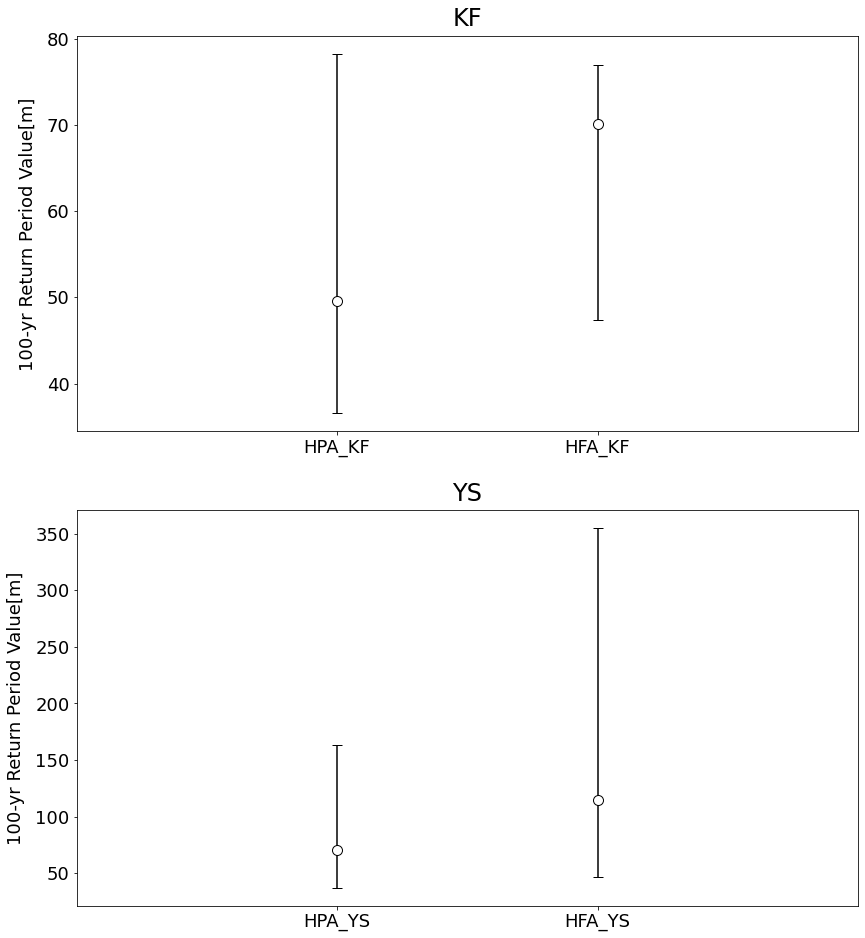

In [3]:
"""
それぞれのモデルのイベントごとの空間最大値を算出する.
それらの上位50個の点に対して, 極値統計解析を行い, 現在と過去で比較する
"""

from csv import reader
import matplotlib.pyplot as plt
import numpy as np
import func

fig = plt.figure(figsize=(14, 16))

MODEL = ['KF', 'YS']
DATA_CNT = 125

for model_num in range(len(MODEL)):
    for num in range(2):
        model = MODEL[model_num]
        if num == 0:
            model = 'HPA_' + model
        else:
            model = 'HFA_' + model + '_c0'
        
        print(model)

        with open('../pot_csv(100)/' + model + '_POT_DATA.csv', 'r') as csv_file:
            csv_reader = reader(csv_file)
            POT = list(csv_reader)
        with open('../pot_csv(100)/' + model + '_POT_INDEX.csv', 'r') as csv_file:
            csv_reader = reader(csv_file)
            POT_INDEX = list(csv_reader)

        DATA = []  # [Hsのindex, Hs]の配列
        for i in range(len(POT)):
            for j in range(len(POT[i])):
                DATA.append([int(POT_INDEX[i][j]), float(POT[i][j])])
        
        # [Hsのindexがsortされる(小さい順)]
        DATA.sort()

        last_index = 0
        max_val = 0

        EVENT_POT = [[]]  # イベントごとのPOTを収納
        for data in DATA:
            if data[0] > last_index + 24 * 7:
                EVENT_POT.append([data[0], data[1]])
                last_index = data[0]
                max_val = data[1]
            else:
                if data[1] > max_val:
                    EVENT_POT[-1] = [data[0], data[1]]
                    last_index = data[0]
                    max_val = data[1]

        POT_DATA = []  # 空間最大波高
        for pot in EVENT_POT:
            POT_DATA.append(pot[1])
        
        # 大きい順にsort
        POT_DATA.sort(reverse=True)
        POT_DATA = POT_DATA[:DATA_CNT]
        print('POTデータの範囲', POT_DATA[-1], '~', POT_DATA[0])
        
        if num == 0:
            RV_ = func.lwm_gpd(data=POT_DATA, error=[0.005], thr=POT_DATA[-1], n=219143, n0=DATA_CNT, con=0.95)
            print('RV：', RV_)
        else:
            RV_0 = func.lwm_gpd(data=POT_DATA, error=[0.005], thr=POT_DATA[-1], n=219143, n0=DATA_CNT, con=0.95)
            print('RV：', RV_0)


    # 描画
    ax = fig.add_subplot(2, 1, model_num + 1)
    a = plt.errorbar(
        x=[1, 2],
        y=[RV_[1], RV_0[1]],
        yerr=np.array(
            [
                [RV_[1] - RV_[0], RV_0[1] - RV_0[0]],
                [RV_[2] - RV_[1], RV_0[2] - RV_0[1]]
            ]
        ),
        capsize=5,
        fmt='o',
        markersize=10,
        ecolor='black',
        markeredgecolor='black',
        color='w'
    )
    ax.set_xlim((0, 3))
    ax.set_title(model[4:6], fontsize=24, pad=10)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['HPA_' + model[4:6], 'HFA_' + model[4:6]], fontsize=18)
    ax.set_ylabel('100-yr Return Period Value[m]', fontsize=18, labelpad=10)
    ax.tick_params(axis='y', labelsize=18)

# plt.savefig("../img/rv_of_tc.png")
plt.show()